# Introduction
Inspired by [Maria Movin (2018)](http://www.nada.kth.se/~ann/exjobb/maria_movin.pdf) I want to attempt to perform spelling correction using a machine translation model.
She uses a very similar model to what I used in `1. Machine Translation - Character Level Model`.

I will attempt to use a similar model, but will also try to use an embedding layer for the characters.
Perhaps the model could learn similarities between some characters?

# Data
I will be using the [Twitter Typo](http://luululu.com/tweet/) data set to train and evaluate my model.
It consists of 39 172 misspelled words and their correct spelling, including some meta data about what type of misspelling it is.
This data set was used by [Gosh and Kristensson (2015)](https://arxiv.org/pdf/1709.06429.pdf) to learn about common spelling mistakes in order to generate a larger data set of corrected words.
As I am running my model on my weak laptop I will opt to not extend the data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Import the Data

In [2]:
data_path = 'data/twitter_typos/typo-corpus-r1.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

rows = []
for line in lines:
    rows.append(line.split('\t')[:3])
    

In [3]:
rows[0]

['york', 'work', 'R2']

In [4]:
rows[-1]

['']

In [5]:
rows = rows[:-1]

In [6]:
df = pd.DataFrame(data=rows, columns=['incorrect', 'correct', 'type'])

In [7]:
df.head()

,incorrect,correct,type
0,york,work,R2
1,prople,people,R2
2,hring,hiring,RM
3,prople,people,R2
4,prople,people,R2


In [8]:
df.shape

(39172, 3)

Add a begginging of word and end of word character to all targets, this will be used to seed new words and determine where a word ends. 
I will use `\t` as start of word and `\n` as end of word characters.

In [9]:
df['correct'] = df['correct'].apply(lambda x: '\t' + x + '\n' )

The four kind of types are:
1. INSERT (IN): a character is added to the original word.
2. REMOVE (RM): a character is removed from the original word.
3. REPLACE1 (R1): the order of character is different from the original word (the number of differences is one).
4. REPLACE2 (R2): a character is different from the original word.

## Explore the data

### Types of Misspellings

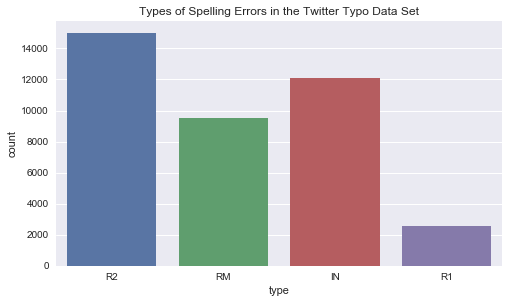

In [10]:
f, ax = plt.subplots(figsize=(8,4.5))
sns.countplot(x='type', data=df)
ax.set_title('Types of Spelling Errors in the Twitter Typo Data Set')

### Number of duplicates

In [11]:
print("Distinct incorrect words: {}".format(df['incorrect'].nunique()))
print("Distinct correct words: {}".format(df['correct'].nunique()))

Distinct incorrect words: 9294
Distinct correct words: 2466


### Missing data

In [12]:
df.isnull().sum()

incorrect    0
correct      0
type         0
dtype: int64

### Number of Unique Characters

In [13]:
def add_char(word):
    for c in word:
        chars.add(c)
chars = set()
df['incorrect'].apply(add_char);
df['correct'].apply(add_char);

In [14]:
len(chars)

29

### Word Length

In [15]:
df['incorrect'].apply(len).describe()

count    39172.000000
mean         4.124553
std          2.088488
min          1.000000
25%          3.000000
50%          3.000000
75%          5.000000
max         16.000000
Name: incorrect, dtype: float64

In [16]:
df['correct'].apply(len).describe()

count    39172.000000
mean         6.058128
std          2.173799
min          2.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         17.000000
Name: correct, dtype: float64

## Encode Characters as Integers
I will encode all characters as integers to make them compatible with the Keras Embedding layer. I keep `0` for padding.
All words will be coverted into lists of integers.

In [17]:
vocab_size = len(chars)

In [60]:
char_mapping = dict(zip(sorted(list(chars)), np.arange(1, vocab_size+1)))
reversed_char_mapping = dict([(b, a) for a, b in char_mapping.items()])

In [19]:
df['X'] = df['incorrect'].apply(lambda x: [char_mapping[c] for c in x])
df['y'] = df['correct'].apply(lambda x: [char_mapping[c] for c in x])

## Divide data into training, dev and test set
When splitting the data into different sets I will be using `type` to strattify the data.
I think it is a good idea to make sure that all sets are representable of all types of errors.

In [20]:
from sklearn.model_selection import train_test_split

In [168]:
df_train, df_test = train_test_split(df, stratify=df['type'], test_size=1/10, random_state=1)
df_train, df_dev = train_test_split(df_train, stratify=df_train['type'], test_size=(2/9), random_state=1)

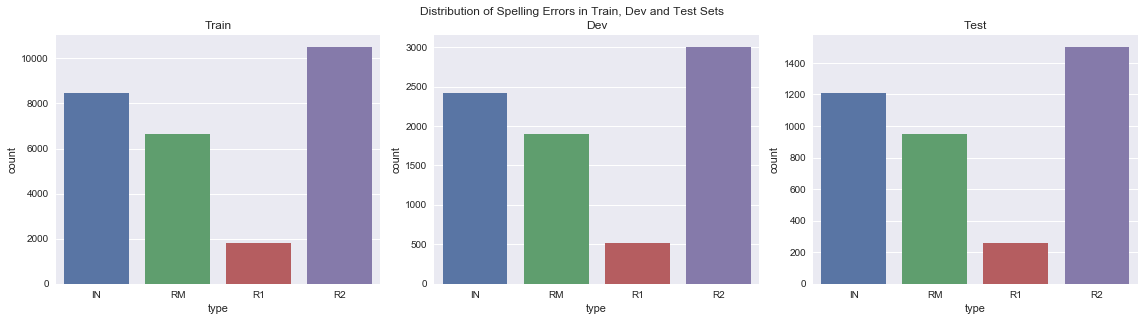

In [22]:
f, ax = plt.subplots(1, 3, figsize=(16,4.5))
for i, name, dfi in zip(np.arange(3), ["Train", "Dev", "Test"], [df_train, df_dev, df_test]):
    sns.countplot(data=dfi, x='type', ax=ax[i], order=['IN', 'RM', 'R1', 'R2'])
    ax[i].set_title(name)
f.tight_layout(rect = [0, 0, 1, .97])
f.suptitle("Distribution of Spelling Errors in Train, Dev and Test Sets")

In [169]:
X_train, y_train = df_train['X'].values, df_train['y'].values
X_dev, y_dev = df_dev['X'].values, df_dev['y'].values
X_test, y_test = df_test['X'].values, df_test['y'].values

## Pad Data
To allow a Keras RNN to process data in batches the whole batces all sequences in one batch needs to be the same length.
This is acheived by padding sentences with trailing `0`'s that will be ignored during training. 

To avoid padding all sentences to be as long as the longest sentence in each set I will sort the data sets.

In [170]:
sorted_idx_train = np.argsort(list(map(lambda x: len(x), X_train)))
sorted_idx_dev = np.argsort(list(map(lambda x: len(x), X_dev)))
sorted_idx_test = np.argsort(list(map(lambda x: len(x), X_test)))

In [171]:
X_train = X_train[sorted_idx_train]
y_train = y_train[sorted_idx_train]
df_train = df_train.iloc[sorted_idx_train]

X_dev = X_dev[sorted_idx_dev]
y_dev = y_dev[sorted_idx_dev]
df_dev = df_dev.iloc[sorted_idx_dev]

X_test = X_test[sorted_idx_test]
y_test = y_test[sorted_idx_test]
df_test = df_test.iloc[sorted_idx_test]

Generator for the padded sequences.

In [172]:
def one_hot(i, n):
    arr = np.zeros(n)
    arr[i] = 1
    return arr

In [173]:
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences
class ShortPaddingGeneratorSeq2Seq(Sequence):
    """
    Class for generating padded sequences
    """
    def __init__(self, x_set, y_set, batch_size, return_sample_weights=True, one_hot_encode=False):
        self.return_sample_weights = return_sample_weights
        self.batch_size = batch_size
        self.x, self.y, self.sample_weights = [], [], []
        self.x2 = []
        # Pad Data so all batches have sequences of equal length
        for idx in range(int(np.ceil(len(x_set) / float(self.batch_size)))):
            batch_x = x_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_y = y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            
            # The input is sorted so the last sequence is the longest
            max_len_x = len(batch_x[-1])
            max_len_y = len(batch_y[-1])
            batch_x = np.array(pad_sequences(batch_x, maxlen=max_len_x, padding='post'))
            batch_y = np.array(pad_sequences(batch_y, maxlen=max_len_y, padding='post'))
            
            #self.sample_weights.append(batch_x != 0)
            self.sample_weights.append(batch_y[:,1:] != 0)
            
            if one_hot_encode:
                batch_x = np.array([np.array([one_hot(i, vocab_size+1) for i in sentence]) for sentence in batch_x])
                batch_y = np.array([np.array([one_hot(i, vocab_size+1) for i in sentence]) for sentence in batch_y])
            
            self.x.append(batch_x)
            self.y.append(batch_y[:,1:])
            # The decoder input s
            self.x2.append(batch_y[:,:-1])
            
            
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        # Fetch the batches
        if self.return_sample_weights:
            return [self.x[idx], self.x2[idx]], self.y[idx], self.sample_weights[idx]
        else:
            return [self.x[idx], self.x2[idx]], self.y[idx]
    
    def set_return_sample_weights(self, flag):
        self.return_sample_weights = flag

Create the generators for each set.

In [174]:
train_gen = ShortPaddingGeneratorSeq2Seq(X_train, y_train, batch_size=64, one_hot_encode=True)
dev_gen = ShortPaddingGeneratorSeq2Seq(X_dev, y_dev, batch_size=64, one_hot_encode=True)
test_gen = ShortPaddingGeneratorSeq2Seq(X_test, y_test, batch_size=64, one_hot_encode=True)

In [175]:
print(train_gen[100][0][0].shape)
print(train_gen[100][0][1].shape)
print(train_gen[100][1].shape)


(64, 2, 30)
(64, 3, 30)
(64, 3, 30)


# One-Hot Encoded Characters
First let's use the model proposed in Francois Chollet's article [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).

In [134]:
# Config
batch_size = 64
latent_dim = 256

In [135]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define the encoder to have one hidden LSTM layer and output its state
encoder_inputs = Input(shape=(None, vocab_size+1))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Only save the states of the encoder, we don't care about it's output
encoder_states = [state_h, state_c]

# Define the decoder, it will use the state of the encoder as its initial state
decoder_inputs = Input(shape=(None, vocab_size+1))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_size+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [136]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [137]:
# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy', weighted_metrics=['accuracy'], sample_weight_mode="temporal")

In [181]:
model.fit_generator(train_gen,
          epochs=10,
          validation_data=dev_gen)

Epoch 1/10
429/429 [==============================] - 45s 105ms/step - loss: 0.3171 - weighted_acc: 0.9044 - val_loss: 0.3307 - val_weighted_acc: 0.9021
Epoch 2/10
429/429 [==============================] - 50s 117ms/step - loss: 0.2635 - weighted_acc: 0.9201 - val_loss: 0.3003 - val_weighted_acc: 0.9102
Epoch 3/10
429/429 [==============================] - 50s 116ms/step - loss: 0.2311 - weighted_acc: 0.9286 - val_loss: 0.2964 - val_weighted_acc: 0.9081
Epoch 4/10
429/429 [==============================] - 52s 120ms/step - loss: 0.2088 - weighted_acc: 0.9351 - val_loss: 0.2982 - val_weighted_acc: 0.9105
Epoch 5/10
429/429 [==============================] - 52s 121ms/step - loss: 0.1963 - weighted_acc: 0.9380 - val_loss: 0.2754 - val_weighted_acc: 0.9185
Epoch 6/10
429/429 [==============================] - 54s 126ms/step - loss: 0.1776 - weighted_acc: 0.9435 - val_loss: 0.2750 - val_weighted_acc: 0.9192
Epoch 7/10
429/429 [==============================] - 56s 131ms/step - loss: 0.168

# Inference

Let's test the model with Chollet's inference model.

In [182]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [183]:
max_decoder_seq_length = 20
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, vocab_size + 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char_mapping['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        #print(output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reversed_char_mapping[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, vocab_size + 1))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [198]:
np.random.seed(1)
for seq_index in np.random.randint(0, len(X_train), 10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = X_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(np.array([np.array([one_hot(i, vocab_size+1) for i in input_seq])]))
    print('-')
    print('Input word:', df_train.iloc[seq_index]['incorrect'])
    print('Target word:', df_train.iloc[seq_index]['correct'].strip())
    print('Corrected word:', decoded_sentence)

-
Input word: yu
Target word: you
Corrected word: you

-
Input word: meg
Target word: me
Corrected word: me

-
Input word: im
Target word: i
Corrected word: i

-
Input word: forr
Target word: for
Corrected word: or

-
Input word: hav
Target word: has
Corrected word: a

-
Input word: tha
Target word: the
Corrected word: a

-
Input word: tqake
Target word: take
Corrected word: a

-
Input word: gottan
Target word: gotta
Corrected word: on

-
Input word: nw
Target word: now
Corrected word: on

-
Input word: goona
Target word: gonna
Corrected word: on



The model has learned some patterns, but seems to often resort to outputting short and simple words.